In [1]:
!git clone https://github.com/facebookresearch/ConvNeXt-V2.git
!pip install timm==0.3.2 tensorboardX six
!pip install submitit

Cloning into 'ConvNeXt-V2'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 44 (delta 10), reused 5 (delta 5), pack-reused 24 (from 1)
Receiving objects: 100% (44/44), 796.52 KiB | 13.97 MiB/s, done.
Resolving deltas: 100% (14/14), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 5.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.12
    Uninstalling timm-1.0.12:
      Successfully uninstalled timm-1.0.12
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 2.4 MB/s eta 0:00:00


In [2]:
!pip install --upgrade timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: timm
    Found existing installation: timm 0.3.2
    Uninstalling timm-0.3.2:
      Successfully uninstalled timm-0.3.2


In [3]:
import timm.data.constants as td_constants
import timm.data
timm.data.OPENAI_CLIP_MEAN = td_constants.OPENAI_CLIP_MEAN
timm.data.OPENAI_CLIP_STD = td_constants.OPENAI_CLIP_STD

In [4]:
%%bash
FILE="/kaggle/working/ConvNeXt-V2/models/utils.py"

if [ -f "$FILE" ]; then
    echo "Modifying $FILE to disable MinkowskiEngine dependency..."
    sed -i.bak 's/^from MinkowskiEngine import SparseTensor/# from MinkowskiEngine import SparseTensor/g' "$FILE"
    echo "Modification complete. A backup was saved as $FILE.bak."
else
    echo "Error: File $FILE not found. Please check your repository structure."
fi

Modifying /kaggle/working/ConvNeXt-V2/models/utils.py to disable MinkowskiEngine dependency...
Modification complete. A backup was saved as /kaggle/working/ConvNeXt-V2/models/utils.py.bak.


In [5]:
import sys
sys.path.append('/kaggle/working/ConvNeXt-V2')
from models.convnextv2 import convnextv2_tiny

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [6]:
import os
import cv2
import math
import time
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import torch.nn as nn
from math import sqrt
from tqdm import tqdm
from pathlib import Path
import torch.optim as optim
import torch.optim as optim
from torchinfo import summary
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from collections import defaultdict
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
dataset = Path(r"/kaggle/input/")
covid_19 = dataset / "covid19-radiography-database" / "COVID-19_Radiography_Dataset"

In [9]:
class_names = [entry.name for entry in os.scandir(covid_19) if entry.is_dir()]
image_paths = []
labels = []

for class_name in class_names:
    class_dir = covid_19 / class_name / 'images'
    if os.path.exists(class_dir):
        file_names = [f_name for f_name in os.listdir(class_dir) if f_name.endswith((".jpeg", ".png"))]

        for f_name in tqdm(file_names, desc=f"Processing {class_name}"):
            image_paths.append(os.path.join(class_dir, f_name))
            labels.append(class_name)

Processing COVID: 100%|██████████| 3616/3616 [00:00<00:00, 585447.51it/s]


In [10]:
def is_black_and_white(image):
    """
    Check if the given image is black and white (grayscale).

    Parameters:
        image (PIL.Image.Image): The image object to check.

    Returns:
        bool: True if the image is black and white, False otherwise.
    """
    return image.mode == 'L'

In [11]:
def process_image(image_path, label):
    """
    Process a single image and return the color type.

    Parameters:
        image_path (str): File path of the image.
        label: Class label of the image.

    Returns:
        tuple: A tuple containing the label and color type ('Black & White' or 'Colored').
    """
    with Image.open(image_path) as image:
        color_type = 'Black & White' if is_black_and_white(image) else 'Colored'
    return label, color_type

def count_images_per_class(image_paths, labels):
    """
    Count the number of black and white and colored images per class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        pandas.DataFrame: DataFrame containing the counts per class in tabular format.
    """
    data = defaultdict(lambda: {'Black & White': 0, 'Colored': 0})

    with ThreadPoolExecutor() as executor:
        processed_results = list(tqdm(executor.map(process_image, image_paths, labels), total=len(image_paths), desc="Processing images"))

    for label, color_type in processed_results:
        data[label][color_type] += 1

    df = pd.DataFrame(data).transpose().reset_index()
    df = df.rename(columns={'index': 'Class'})
    return df

result_df = count_images_per_class(image_paths, labels)
print(result_df)

Processing images: 100%|██████████| 21165/21165 [00:21<00:00, 992.55it/s] 

             Class  Black & White  Colored
0           Normal          10192        0
1     Lung_Opacity           6012        0
2  Viral Pneumonia           1205      140
3            COVID           3616        0


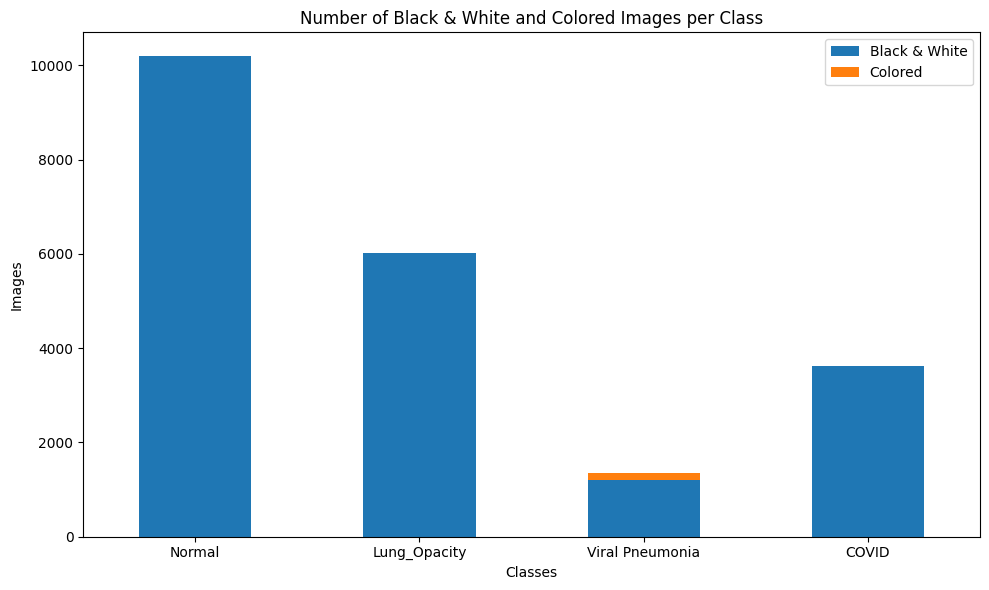

In [12]:
def visualize_images_per_class(result_df, class_column='Class', bw_column='Black & White', colored_column='Colored'):
    """
    Visualize the number of black and white images and colored images per class.

    Parameters:
        result_df (pandas.DataFrame): DataFrame containing the counts per class.
        class_column (str): Name of the column containing the class labels.
        bw_column (str): Name of the column containing the count of black and white images.
        colored_column (str): Name of the column containing the count of colored images.

    Returns:
        None
    """
    result_df.set_index(class_column, inplace=True)

    ax = result_df.plot(kind='bar', stacked=True, figsize=(10, 6), rot=0)
    ax.set_xlabel('Classes')
    ax.set_ylabel('Images')
    ax.set_title('Number of Black & White and Colored Images per Class')
    ax.legend(["Black & White", "Colored"])

    plt.tight_layout()
    plt.show()

visualize_images_per_class(result_df)

Loading and displaying images: 100%|██████████| 4/4 [00:00<00:00, 250.66it/s]


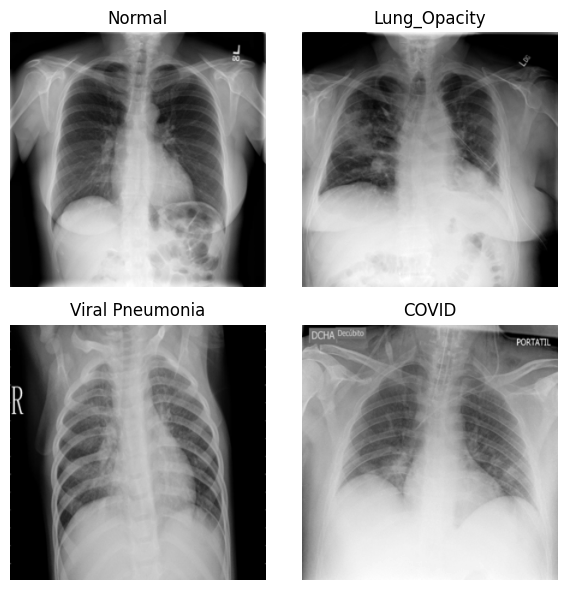

In [13]:
def group_images_by_class(image_paths, labels):
    """
    Group image paths by class label.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.

    Returns:
        dict: A dictionary where the keys are class labels, and the values are lists of image paths for each class.
    """
    class_to_images = {}
    for img_path, label in zip(image_paths, labels):
        if label not in class_to_images:
            class_to_images[label] = []
        class_to_images[label].append(img_path)
    return class_to_images

def display_images_per_class(image_paths, labels):
    class_to_images = group_images_by_class(image_paths, labels)
    num_classes = len(class_to_images)

    num_rows, num_cols = 1, num_classes
    if num_classes == 4:
        num_rows, num_cols = 2, 2
    elif num_classes == 6:
        num_rows, num_cols = 2, 3

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))

    with tqdm(total=num_classes, desc="Loading and displaying images") as pbar:
        for i, (class_label, image_paths_for_class) in enumerate(class_to_images.items()):
            selected_image_path = random.choice(image_paths_for_class)
            try:
                selected_image = Image.open(selected_image_path)
                ax = axs[i // num_cols, i % num_cols]
                ax.imshow(selected_image, cmap='gray')
                ax.set_title(class_label)
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image: {selected_image_path}")
                print(e)

            pbar.update(1)

    plt.tight_layout()
    plt.show()

display_images_per_class(image_paths, labels)

Displaying Images: 100%|██████████| 4/4 [00:24<00:00,  6.18s/it]


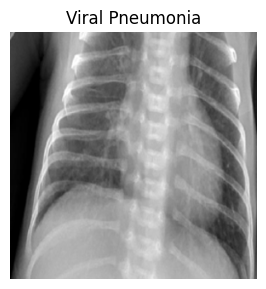

In [14]:
@lru_cache(maxsize=100)
def load_colored_image(image_path):
    """
    Load an image using Pillow and check if it is a colored image (not grayscale).

    Parameters:
        image_path (str): The path to the image file.

    Returns:
        numpy.ndarray or None: The loaded colored image as a NumPy array, or None if grayscale.
    """
    try:
        img = Image.open(image_path)
        if not is_black_and_white(img):
            return np.array(img)
    except (IOError, OSError) as e:
        raise Exception(f"Error loading image '{image_path}': {e}")
    return None

def display_colored_images(image_paths, labels, num_images_per_class=1):
    """
    Randomly display colored images for each class.

    Parameters:
        image_paths (list): List of file paths of the images.
        labels (list): List of corresponding class labels.
        num_images_per_class (int): Number of images to display per class.

    Returns:
        None
    """
    plt.figure(figsize=(8, 6))
    displayed_classes = 0
    unique_labels = set(labels)

    shuffled_labels = list(unique_labels)
    random.shuffle(shuffled_labels)

    for class_label in tqdm(shuffled_labels, desc="Displaying Images"):
        image_paths_for_class = [img_path for img_path, lbl in zip(image_paths, labels) if lbl == class_label]
        colored_images_for_class = [img_path for img_path in image_paths_for_class if load_colored_image(img_path) is not None]

        if len(colored_images_for_class) == 0:
            continue

        num_images_to_display = min(len(colored_images_for_class), num_images_per_class)

        for i in range(num_images_to_display):
            selected_image_path = random.choice(colored_images_for_class)
            selected_image = load_colored_image(selected_image_path)

            displayed_classes += 1
            plt.subplot(2, 3, displayed_classes)
            plt.imshow(selected_image)
            plt.title(f"{class_label}")
            plt.axis('off')

            if displayed_classes == 6:
                break

        if displayed_classes == 6:
            break

    plt.tight_layout()
    plt.show()

display_colored_images(image_paths, labels, num_images_per_class=1)

In [15]:
# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
classes = label_encoder.classes_
num_classes = len(classes)

# First: split off the test set (10% of the total)
remaining_paths, test_paths, remaining_labels, test_labels = train_test_split(
    image_paths,
    labels_encoded,
    test_size=0.1,
    random_state=42,
    stratify=labels_encoded
)

# Second: from the remaining 90%, split off the validation set.
# To have validation = 10% of the total, we use test_size = 0.1 / 0.9 ≈ 0.1111 here.
train_paths, val_paths, train_labels, val_labels = train_test_split(
    remaining_paths,
    remaining_labels,
    test_size=0.1111,
    random_state=42,
    stratify=remaining_labels
)

# Calculate total counts and percentages
total_samples = len(labels_encoded)
total_train_samples = len(train_paths)
total_val_samples = len(val_paths)
total_test_samples = len(test_paths)

train_percentage = (total_train_samples / total_samples) * 100
val_percentage = (total_val_samples / total_samples) * 100
test_percentage = (total_test_samples / total_samples) * 100

# Compute class distribution counts for each split
train_counts = pd.Series(train_labels).value_counts().sort_index()
val_counts = pd.Series(val_labels).value_counts().sort_index()
test_counts = pd.Series(test_labels).value_counts().sort_index()

# Create DataFrames for reporting (assuming 'class_names' is defined)
train_df = pd.DataFrame({'Train Samples': train_counts})
val_df = pd.DataFrame({'Validation Samples': val_counts})
test_df = pd.DataFrame({'Test Samples': test_counts})
train_df.index = val_df.index = test_df.index = class_names

# Print summary information
print("Total Train Samples:", total_train_samples)
print("Total Validation Samples:", total_val_samples)
print("Total Test Samples:", total_test_samples)
print("\nPercentage of Split:")
print("Train: {:.2f}%".format(train_percentage))
print("Validation: {:.2f}%".format(val_percentage))
print("Test: {:.2f}%".format(test_percentage))
print("\nClass Distribution:")
result_df = pd.concat([train_df, val_df, test_df], axis=1)
print(result_df)

Total Train Samples: 16931
Total Validation Samples: 2117
Total Test Samples: 2117

Percentage of Split:
Train: 80.00%
Validation: 10.00%
Test: 10.00%

Class Distribution:
                 Train Samples  Validation Samples  Test Samples
Normal                    2892                 362           362
Lung_Opacity              4810                 601           601
Viral Pneumonia           8153                1020          1019
COVID                     1076                 134           135


In [16]:
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_labels, transform=None):
        """
        Custom Dataset class to load and preprocess images.

        Args:
            img_paths (list): List of image file paths.
            img_labels (list): List of corresponding image labels.
            transform (callable, optional): Transform to apply to images. Defaults to None.
        """
        self.img_paths = img_paths
        self.img_labels = img_labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = cv2.imread(str(self.img_paths[index]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        pil_img = Image.fromarray(img)
        
        transformed_img = self.transform(pil_img)

        label = self.img_labels[index]
        return transformed_img, label

In [17]:
BATCH_SIZE = 16

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = ImageDataset(train_paths, train_labels, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

val_dataset = ImageDataset(val_paths, val_labels, transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

test_dataset = ImageDataset(test_paths, test_labels, transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

train_steps = len(train_loader)
val_steps = len(val_loader)
test_steps = len(test_loader)

In [18]:
# Create a ConvNeXt V2 Tiny model (e.g., for 1000-class classification)
model = convnextv2_tiny(num_classes=4, drop_path_rate=0.1, head_init_scale=1.0)
model.to(device)

# Print model architecture summary
summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNeXtV2                               [1, 4]                    --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Sequential: 2-1                   [1, 96, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 96, 56, 56]           4,704
│    │    └─LayerNorm: 3-2               [1, 96, 56, 56]           192
├─ModuleList: 1-8                        --                        (recursive)
│    └─Sequential: 2-2                   [1, 96, 56, 56]           --
│    │    └─Block: 3-3                   [1, 96, 56, 56]           79,968
│    │    └─Block: 3-4                   [1, 96, 56, 56]           79,968
│    │    └─Block: 3-5                   [1, 96, 56, 56]           79,968
├─ModuleList: 1-7                        --                        (recursive)
│    └─Sequential: 2-3                   [1, 192, 28, 28]          --
│    │    └─LayerNorm: 3-6               [

In [19]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    auc_avg = np.mean(auc_scores)

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [20]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

In [21]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

num_epochs = 25
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    
    average_loss = total_loss / len(train_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(training_metrics_line)
    
    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])
    
    # Validation loop
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    start_time = time.time()
    
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            all_predictions.extend(outputs.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
    
    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    
    average_loss = total_loss / len(val_loader)
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "
    print(validation_metrics_line)
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])
    
    # Step the scheduler to decay the learning rate by 0.995
    scheduler.step()

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / num_epochs
avg_validation_time_per_epoch = total_validation_time / num_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/25]: 100%|██████████| 1059/1059 [03:25<00:00,  5.16it/s]


Metrics - loss: 1.0426, accuracy: 0.5358, precision: 0.5279, recall: 0.5358, f1_score: 0.4940, specificity: 0.1248, sensitivity: 0.9736, mcc: 0.2259, auc: 0.6967


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.23it/s]


Metrics - loss: 0.7429, accuracy: 0.6996, precision: 0.7189, recall: 0.6996, f1_score: 0.7027, specificity: 0.6768, sensitivity: 0.8957, mcc: 0.5628, auc: 0.8581


Training Model - Epoch [2/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.6304, accuracy: 0.7525, precision: 0.7506, recall: 0.7525, f1_score: 0.7492, specificity: 0.5709, sensitivity: 0.9507, mcc: 0.6155, auc: 0.8870


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.28it/s]


Metrics - loss: 0.5437, accuracy: 0.7903, precision: 0.7965, recall: 0.7903, f1_score: 0.7897, specificity: 0.7707, sensitivity: 0.9225, mcc: 0.6778, auc: 0.9192


Training Model - Epoch [3/25]: 100%|██████████| 1059/1059 [03:25<00:00,  5.17it/s]


Metrics - loss: 0.4992, accuracy: 0.8044, precision: 0.8039, recall: 0.8044, f1_score: 0.8030, specificity: 0.6954, sensitivity: 0.9581, mcc: 0.6978, auc: 0.9225


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.16it/s]


Metrics - loss: 0.4922, accuracy: 0.8063, precision: 0.8188, recall: 0.8063, f1_score: 0.8052, specificity: 0.6077, sensitivity: 0.9863, mcc: 0.7048, auc: 0.9431


Training Model - Epoch [4/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.4157, accuracy: 0.8415, precision: 0.8415, recall: 0.8415, f1_score: 0.8408, specificity: 0.7766, sensitivity: 0.9684, mcc: 0.7559, auc: 0.9421


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.17it/s]


Metrics - loss: 0.4044, accuracy: 0.8436, precision: 0.8477, recall: 0.8436, f1_score: 0.8429, specificity: 0.8591, sensitivity: 0.9493, mcc: 0.7600, auc: 0.9509


Training Model - Epoch [5/25]: 100%|██████████| 1059/1059 [03:25<00:00,  5.16it/s]


Metrics - loss: 0.3572, accuracy: 0.8645, precision: 0.8647, recall: 0.8645, f1_score: 0.8640, specificity: 0.8368, sensitivity: 0.9764, mcc: 0.7916, auc: 0.9527


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.17it/s]


Metrics - loss: 0.3771, accuracy: 0.8607, precision: 0.8609, recall: 0.8607, f1_score: 0.8603, specificity: 0.8702, sensitivity: 0.9595, mcc: 0.7871, auc: 0.9558


Training Model - Epoch [6/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.3047, accuracy: 0.8863, precision: 0.8865, recall: 0.8863, f1_score: 0.8859, specificity: 0.8731, sensitivity: 0.9811, mcc: 0.8254, auc: 0.9609


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.22it/s]


Metrics - loss: 0.4183, accuracy: 0.8337, precision: 0.8481, recall: 0.8337, f1_score: 0.8356, specificity: 0.8840, sensitivity: 0.9595, mcc: 0.7562, auc: 0.9576


Training Model - Epoch [7/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.2515, accuracy: 0.9061, precision: 0.9062, recall: 0.9061, f1_score: 0.9058, specificity: 0.9070, sensitivity: 0.9847, mcc: 0.8560, auc: 0.9687


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.36it/s]


Metrics - loss: 0.4279, accuracy: 0.8630, precision: 0.8677, recall: 0.8630, f1_score: 0.8615, specificity: 0.7320, sensitivity: 0.9932, mcc: 0.7895, auc: 0.9641


Training Model - Epoch [8/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.2088, accuracy: 0.9219, precision: 0.9219, recall: 0.9219, f1_score: 0.9216, specificity: 0.9284, sensitivity: 0.9869, mcc: 0.8804, auc: 0.9746


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.25it/s]


Metrics - loss: 0.3706, accuracy: 0.8677, precision: 0.8699, recall: 0.8677, f1_score: 0.8666, specificity: 0.8232, sensitivity: 0.9812, mcc: 0.7965, auc: 0.9583


Training Model - Epoch [9/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.1690, accuracy: 0.9373, precision: 0.9373, recall: 0.9373, f1_score: 0.9371, specificity: 0.9547, sensitivity: 0.9917, mcc: 0.9040, auc: 0.9803


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.36it/s]


Metrics - loss: 0.3636, accuracy: 0.8781, precision: 0.8792, recall: 0.8781, f1_score: 0.8783, specificity: 0.8619, sensitivity: 0.9829, mcc: 0.8126, auc: 0.9655


Training Model - Epoch [10/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.1316, accuracy: 0.9523, precision: 0.9522, recall: 0.9523, f1_score: 0.9522, specificity: 0.9699, sensitivity: 0.9942, mcc: 0.9270, auc: 0.9849


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.01it/s]


Metrics - loss: 0.3904, accuracy: 0.8810, precision: 0.8831, recall: 0.8810, f1_score: 0.8816, specificity: 0.8867, sensitivity: 0.9840, mcc: 0.8186, auc: 0.9672


Training Model - Epoch [11/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.1064, accuracy: 0.9630, precision: 0.9630, recall: 0.9630, f1_score: 0.9629, specificity: 0.9706, sensitivity: 0.9956, mcc: 0.9433, auc: 0.9890


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.33it/s]


Metrics - loss: 0.4777, accuracy: 0.8640, precision: 0.8667, recall: 0.8640, f1_score: 0.8639, specificity: 0.9530, sensitivity: 0.9527, mcc: 0.7961, auc: 0.9644


Training Model - Epoch [12/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.0755, accuracy: 0.9722, precision: 0.9722, recall: 0.9722, f1_score: 0.9722, specificity: 0.9820, sensitivity: 0.9958, mcc: 0.9575, auc: 0.9936


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.28it/s]


Metrics - loss: 0.4851, accuracy: 0.8729, precision: 0.8752, recall: 0.8729, f1_score: 0.8717, specificity: 0.8536, sensitivity: 0.9863, mcc: 0.8046, auc: 0.9695


Training Model - Epoch [13/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.0591, accuracy: 0.9790, precision: 0.9790, recall: 0.9790, f1_score: 0.9790, specificity: 0.9841, sensitivity: 0.9976, mcc: 0.9679, auc: 0.9956


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.00it/s]


Metrics - loss: 0.5196, accuracy: 0.8663, precision: 0.8681, recall: 0.8663, f1_score: 0.8669, specificity: 0.8840, sensitivity: 0.9744, mcc: 0.7960, auc: 0.9656


Training Model - Epoch [14/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.0500, accuracy: 0.9827, precision: 0.9827, recall: 0.9827, f1_score: 0.9827, specificity: 0.9858, sensitivity: 0.9976, mcc: 0.9735, auc: 0.9966


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.23it/s]


Metrics - loss: 0.5457, accuracy: 0.8767, precision: 0.8768, recall: 0.8767, f1_score: 0.8764, specificity: 0.8812, sensitivity: 0.9840, mcc: 0.8104, auc: 0.9698


Training Model - Epoch [15/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.0445, accuracy: 0.9844, precision: 0.9844, recall: 0.9844, f1_score: 0.9844, specificity: 0.9848, sensitivity: 0.9974, mcc: 0.9762, auc: 0.9973


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.21it/s]


Metrics - loss: 0.5472, accuracy: 0.8748, precision: 0.8745, recall: 0.8748, f1_score: 0.8746, specificity: 0.8895, sensitivity: 0.9744, mcc: 0.8088, auc: 0.9690


Training Model - Epoch [16/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.0370, accuracy: 0.9882, precision: 0.9882, recall: 0.9882, f1_score: 0.9882, specificity: 0.9872, sensitivity: 0.9977, mcc: 0.9819, auc: 0.9980


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.28it/s]


Metrics - loss: 0.5501, accuracy: 0.8725, precision: 0.8737, recall: 0.8725, f1_score: 0.8720, specificity: 0.8453, sensitivity: 0.9875, mcc: 0.8033, auc: 0.9679


Training Model - Epoch [17/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.0346, accuracy: 0.9880, precision: 0.9880, recall: 0.9880, f1_score: 0.9880, specificity: 0.9896, sensitivity: 0.9981, mcc: 0.9817, auc: 0.9981


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.36it/s]


Metrics - loss: 0.5347, accuracy: 0.8795, precision: 0.8807, recall: 0.8795, f1_score: 0.8796, specificity: 0.8481, sensitivity: 0.9863, mcc: 0.8144, auc: 0.9707


Training Model - Epoch [18/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.0329, accuracy: 0.9888, precision: 0.9888, recall: 0.9888, f1_score: 0.9888, specificity: 0.9872, sensitivity: 0.9978, mcc: 0.9828, auc: 0.9984


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.23it/s]


Metrics - loss: 0.5722, accuracy: 0.8734, precision: 0.8748, recall: 0.8734, f1_score: 0.8739, specificity: 0.8812, sensitivity: 0.9846, mcc: 0.8065, auc: 0.9698


Training Model - Epoch [19/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.0292, accuracy: 0.9902, precision: 0.9902, recall: 0.9902, f1_score: 0.9902, specificity: 0.9876, sensitivity: 0.9974, mcc: 0.9850, auc: 0.9987


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.16it/s]


Metrics - loss: 0.6641, accuracy: 0.8592, precision: 0.8688, recall: 0.8592, f1_score: 0.8609, specificity: 0.8232, sensitivity: 0.9903, mcc: 0.7890, auc: 0.9694


Training Model - Epoch [20/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.0276, accuracy: 0.9909, precision: 0.9909, recall: 0.9909, f1_score: 0.9909, specificity: 0.9893, sensitivity: 0.9983, mcc: 0.9861, auc: 0.9988


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.22it/s]


Metrics - loss: 0.6639, accuracy: 0.8772, precision: 0.8786, recall: 0.8772, f1_score: 0.8756, specificity: 0.9006, sensitivity: 0.9778, mcc: 0.8122, auc: 0.9690


Training Model - Epoch [21/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.0292, accuracy: 0.9904, precision: 0.9904, recall: 0.9904, f1_score: 0.9904, specificity: 0.9896, sensitivity: 0.9984, mcc: 0.9853, auc: 0.9986


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 17.68it/s]


Metrics - loss: 0.6535, accuracy: 0.8772, precision: 0.8770, recall: 0.8772, f1_score: 0.8769, specificity: 0.8950, sensitivity: 0.9766, mcc: 0.8115, auc: 0.9691


Training Model - Epoch [22/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.0228, accuracy: 0.9921, precision: 0.9921, recall: 0.9921, f1_score: 0.9921, specificity: 0.9903, sensitivity: 0.9981, mcc: 0.9880, auc: 0.9991


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.35it/s]


Metrics - loss: 0.7732, accuracy: 0.8640, precision: 0.8686, recall: 0.8640, f1_score: 0.8619, specificity: 0.9199, sensitivity: 0.9567, mcc: 0.7933, auc: 0.9675


Training Model - Epoch [23/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.0244, accuracy: 0.9915, precision: 0.9915, recall: 0.9915, f1_score: 0.9915, specificity: 0.9927, sensitivity: 0.9984, mcc: 0.9870, auc: 0.9991


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 17.83it/s]


Metrics - loss: 0.6986, accuracy: 0.8682, precision: 0.8716, recall: 0.8682, f1_score: 0.8667, specificity: 0.8425, sensitivity: 0.9869, mcc: 0.7976, auc: 0.9696


Training Model - Epoch [24/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.0188, accuracy: 0.9936, precision: 0.9936, recall: 0.9936, f1_score: 0.9936, specificity: 0.9910, sensitivity: 0.9986, mcc: 0.9902, auc: 0.9993


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.34it/s]


Metrics - loss: 0.6778, accuracy: 0.8725, precision: 0.8730, recall: 0.8725, f1_score: 0.8725, specificity: 0.9061, sensitivity: 0.9732, mcc: 0.8065, auc: 0.9685


Training Model - Epoch [25/25]: 100%|██████████| 1059/1059 [03:24<00:00,  5.17it/s]


Metrics - loss: 0.0203, accuracy: 0.9933, precision: 0.9933, recall: 0.9933, f1_score: 0.9933, specificity: 0.9914, sensitivity: 0.9988, mcc: 0.9897, auc: 0.9993


Validating Model: 100%|██████████| 133/133 [00:07<00:00, 18.28it/s]

Metrics - loss: 0.7884, accuracy: 0.8512, precision: 0.8561, recall: 0.8512, f1_score: 0.8511, specificity: 0.9530, sensitivity: 0.9379, mcc: 0.7762, auc: 0.9667
Total Training Time: 1:25:20.944701
Total Validation Time: 0:03:02.782283
Average Training Time per Epoch: 0:03:24.837788
Average Validation Time per Epoch: 0:00:07.311291


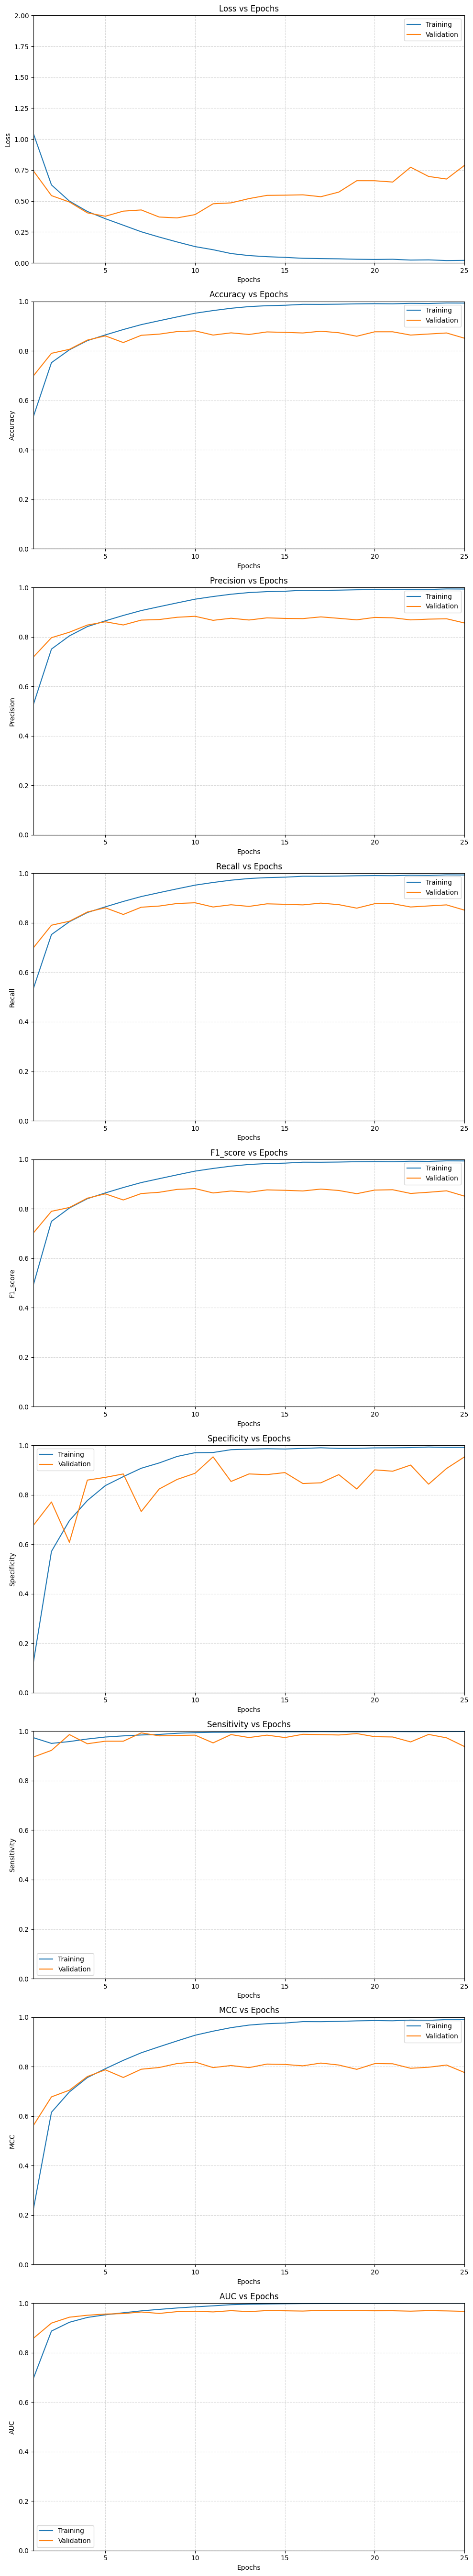

In [22]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [23]:
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 133/133 [00:07<00:00, 18.27it/s]

Metrics - loss: 0.9640, accuracy: 0.8422, precision: 0.8498, recall: 0.8422, f1_score: 0.8425, specificity: 0.9558, sensitivity: 0.9265, mcc: 0.7650, auc: 0.9608


In [24]:
true_labels = np.array(all_targets)

predicted_labels = np.argmax(np.array(all_predictions), axis=1)

true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                 precision    recall  f1-score   support

          COVID     0.7284    0.9558    0.8268       362
   Lung_Opacity     0.8545    0.7720    0.8112       601
         Normal     0.8825    0.8400    0.8607      1019
Viral Pneumonia     0.9070    0.8667    0.8864       135

       accuracy                         0.8422      2117
      macro avg     0.8431    0.8586    0.8463      2117
   weighted avg     0.8498    0.8422    0.8425      2117

There were 334 errors in 2117 tests for an accuracy of  84.22


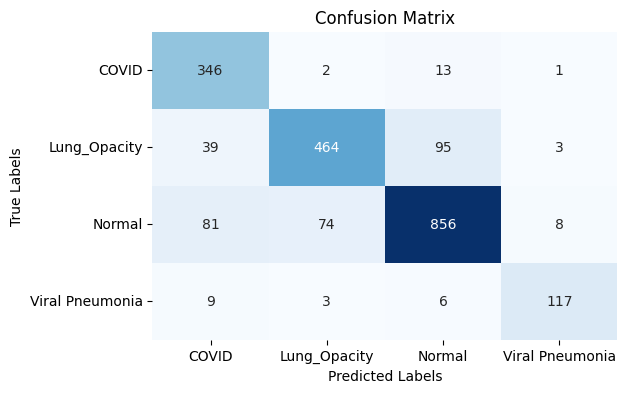

In [25]:
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(true_labels, predicted_labels):
    confusion_matrix[t, p] += 1

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()